<a href="https://colab.research.google.com/github/SolinSM/GAN/blob/main/semina2_GAN_1-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test GAN Modell

In [3]:
#!pip install tensorflow==2.15.0 scikit-learn==1.2.2 keras==2.15.0   #python 3.10.12

## ----- Libraries ----- ##
#for read csv file
import os
import pandas as pd
import numpy as np
import random


# pre-process
##for stop word
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

## not used now
#import unicodedata     # Remove accents
#import string


import sklearn

## for tokenization
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer      ## WordPunctTokenizer --> splits words based on punctuation boundaries.

## for divide data to (train / test/ validate)
from sklearn.model_selection import train_test_split


# for one-hor encode (sentence to 2D)
from sklearn.preprocessing import OneHotEncoder

# for TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# for plot
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder


# for GAN
import tensorflow as tf
from tensorflow.keras.models import Sequential        ## new
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input,
    Concatenate,
    Embedding,
    Dense,
    LeakyReLU,
    BatchNormalization,
    Dropout,
    Reshape,
    LSTM
)

import keras
from keras.optimizers import Adam

import matplotlib.pyplot as plt         ## new

import time
# taqadum in arabic , progress/process in english
from tqdm.notebook import tqdm
#from tqdm import tqdm


# Suppress warnings from numpy
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)


import keras.backend as K
import numpy as np


# for Evaluate
from sklearn.metrics import classification_report


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
print(tf. __version__)      # tensorflow version   2.15.0
!python --version           # python version    3.10.12
print(sklearn.__version__)         # scikit-learn version    1.2.2
print(keras.__version__)           # keras version    2.15.0

2.15.0
Python 3.10.12
1.2.2
2.15.0


In [6]:
## ---- Color + Style Text ---- ##
colors_list = [
    'Red', 'Green', 'Blue', 'Purple', 'Orange', 'Pink', 'Brown', 'Yellow',
    'Cyan', 'Magenta', 'Lime', 'Teal', 'Lavender', 'Maroon', 'Navy', 'Olive', 'Silver', 'Gold',
    'Indigo', 'Turquoise', 'Beige', 'Crimson', 'Salmon','Tan','Lime', 'Fuchsia', 'Plum',
    'Tomato', 'Violet']

class TextStyle:
    # Font Styles
    BOLD = '\033[1m'
    DIM = '\033[2m'
    UNDERLINE = '\033[4m'
    BLINK = '\033[5m'
    REVERSE = '\033[7m'
    RESET_ALL = '\033[0m'

    # Font Colors
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'

    # Background Colors
    BG_BLACK = '\033[40m'
    BG_RED = '\033[41m'
    BG_GREEN = '\033[42m'
    BG_YELLOW = '\033[43m'
    BG_BLUE = '\033[44m'
    BG_MAGENTA = '\033[45m'
    BG_CYAN = '\033[46m'
    BG_WHITE = '\033[47m'


In [7]:
## ---- definition ---- ##

NUM_DISCRIMINATORS = 3
GENERATOR_DROPOUT_RATE = 0.2  #0.1
DISCRIMINATOR_DROPOUT_RATE = 0.3      #Adjust the dropout rate to prevent overfitting during training.
LEAKY_RELU_ALPA = 0.2

NUM_EPOCHS = 500      #1000
BATCH_SIZE = 128      #30
OPTIMIZER_LR = 0.0001                 # learning rate
OPTIMIZER_BETAS = (0.5, 0.999)

# Save losses for plotting
d0_real_losses = []   # left discriminator losses   (disc 0)
d0_fake_losses = []   # left discriminator losses   (disc 0)
d0_losses      = []   # discriminator losses        (disc 0)

d1_real_losses = []   # Middle discriminator losses (disc 1)
d1_fake_losses = []   # Middle discriminator losses (disc 1)
d1_losses      = []   # discriminator losses        (disc 1)

d2_real_losses = []   # right discriminator losses  (disc 2)
d2_fake_losses = []   # right discriminator losses  (disc 2)
d2_losses      = []   # discriminator losses        (disc 2)

g_losses       = []   # generator losses
d_losses       = []   # discriminator losses



In [8]:
## ---- Read CSV Files ---- ##

""" ----------------- Read CSV File Function ----------------- """
def read_csv_files(dataset_directory, percent):
  print(f"{TextStyle.BOLD}{TextStyle.BLUE}------------ Read CSV Files ------------{TextStyle.RESET_ALL}")

  files = [f for f in os.listdir(dataset_directory) if f.endswith('.csv')]

  if files == []:
    print('Not found any csv files')
  else:
    print('Your files are: ', files)

    np_array_values = []
    data_df = pd.DataFrame()
    firstFile = True

    for file in files:
      file_path = os.path.join(dataset_directory, file)   # csv_file_path
      print('File Path: ', file_path)

      try:
        df = ''
        df = pd.read_csv(file_path, encoding = "ISO-8859-1")  #.head()   #,low_memory=False   ISO-8859-1
        total_rows = len(df)
        print('Total rows in df/file: ', total_rows)

        num_rows = int(total_rows * (percent / 100))
        print('Total rows in df/file 100%: ', num_rows)


        """ Start From Teacher Code """
        # Generate a list of random indices
        random_indices = random.sample(range(total_rows), num_rows)
        #print('random_indices: ' , random_indices)

        # Select the random rows from the DataFrame
        temp_df = df.iloc[random_indices]
        if(firstFile):
          # Concatenate all DataFrames into one
          data_df = temp_df.copy()
          firstFile = False
        else:
          # Concatenate all DataFrames into one
          data_df = pd.concat([data_df,temp_df], ignore_index=True)

        print(data_df)
        return data_df
        """ End From Teacher Code """

        ## Add DataFrame to new CSV file
        #new_csv_file_path = os.path.join(dataset_directory, 'new_sqli.csv')  # "/content/dataset/new_sqli.csv"
        #df.to_csv(new_csv_file_path, index=False)

      except Exception as e:
        print('Can not Read File called : ', file)
        print('File path: ', file_path)
        print("Errpr Exception e : ", e)


# ---------------------------> Read Data of CSV Files <--------------------------- #
dataset_directory = "/content/datasets"   #files_path
percent = 100
df = read_csv_files(dataset_directory,percent)
print('len data : ' , len(df))

class_Col = 'attack_type'
min_rows_per_class = 2000  #50000
origin_data = df

------------ Read CSV Files ------------
Your files are:  ['before_only_4000.csv']
File Path:  /content/datasets/before_only_4000.csv
Total rows in df/file:  4000
Total rows in df/file 100%:  4000
                                               sentence  attack_type  \
2535                                          salamanca            0   
871    UNION ALL SELECT NULL, NULL, NULL, NULL, NULL...            1   
917               1 where 8102 = 8102 and 9198 = 9198--            1   
1882  "  )  )   UNION ALL SELECT NULL, NULL, NULL, N...            1   
3015                                   urgeles montanuy            0   
...                                                 ...          ...   
1057  1' or exp ( ~ ( select * from  ( select concat...            1   
758   "  )  )   )  UNION ALL SELECT NULL, NULL, NULL...            1   
2393                                         es93n576te            0   
2180                                     buils szebesta            0   
540        

------------ Pre-Proccess ------------


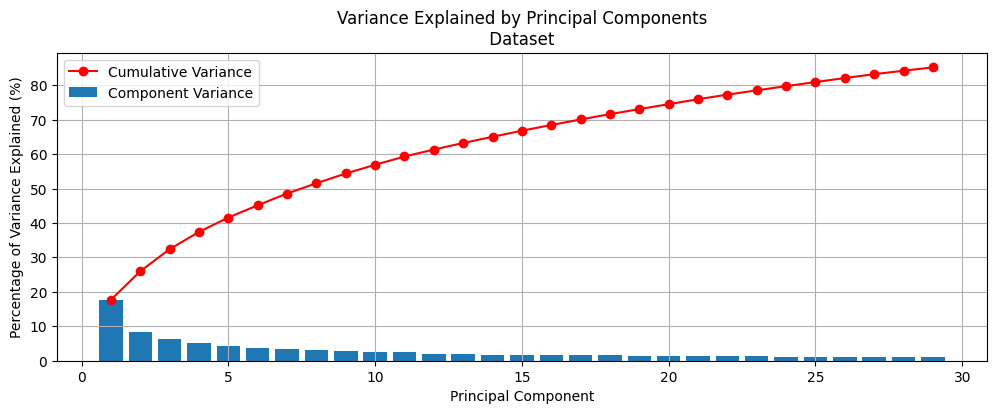

In [11]:
## ---- Pre-process ---- ##
print(f"{TextStyle.BOLD}{TextStyle.BLUE}------------ Pre-Proccess ------------{TextStyle.RESET_ALL}")


# Step 1.1: One-hot encode attack_type
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y = encoder.fit_transform(df[['attack_type']])


# Step 11.2: create X by remove 'attack_type'
#new_df_data = df.drop(columns=['attack_type'], inplace=True)
new_df = df.copy()
#X = new_df.drop(columns=['attack_type'], inplace=True)
X = df[['sentence', 'len_payload']]  # Features: 'sentence' and 'len_payload'


# Step 11.3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Step 11.4: TfidfVectorizer  ---<<>>--- ( to 'sentence' column)
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Set max_features to 50 for simplicity (Limit to top 100 features)   #dtype='float32'
## --- X_train
X_tfidf = tfidf_vectorizer.fit_transform(X_train['sentence'])            # without Tokenization step
X_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()
X_train_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=X_tfidf_selected_features)     #X_df_tfidf
## --- X_test
X_test_tfidf_values = tfidf_vectorizer.transform(X_test['sentence'])      # without Tokenization step
X_test_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()
X_test_tfidf_df = pd.DataFrame(X_test_tfidf_values.toarray(), columns=X_test_tfidf_selected_features)

x_train_data = X_train_tfidf_df
x_test_data = X_test_tfidf_df
# Step 11.5: Concatenate TF-IDF features with 'len_payload' column
# First, drop the 'sentence' column from X_train and X_test and then concatenate with TF-IDF features
#x_train_data = pd.concat([X_train.drop(columns=['sentence']).reset_index(drop=True), X_train_tfidf_df], axis=1)
#x_test_data = pd.concat([X_test.drop(columns=['sentence']).reset_index(drop=True), X_test_tfidf_df], axis=1)
###x_train_data = pd.concat([ X_train.drop(columns=['sentence'], inplace=True) , X_train_tfidf_df], axis=1)
###x_test_data = pd.concat([ X_test.drop(columns=['sentence'], inplace=True)  , X_test_tfidf_df], axis=1)


"""
# Step 11.6: Apply MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(x_train_data)     # Scale all features (TF-IDF + len_payload)
x_train_data_scaled = pd.DataFrame(X_train_scaled, columns=x_train_data.columns)     #X_train_scaled_df

X_test_scaled = scaler.fit_transform(x_test_data)     # Scale all features (TF-IDF + len_payload)
x_test_data_scaled = pd.DataFrame(X_test_scaled, columns=x_test_data.columns)        #X_test_scaled_df


# Step 11.7: Combine features using np.hstack
# We want to combine the scaled TF-IDF features with the 'len_payload' feature, which is already scaled
X_train_combined = np.hstack([x_train_data_scaled.values])  # For training data
X_test_combined = np.hstack([x_test_data_scaled.values])    # For test data
"""



# Step 11.5: Apply MinMaxScaler
scaler = MinMaxScaler()

## --- X_train
len_payload_scaled_train = scaler.fit_transform(X_train[['len_payload']])    # Only scale the 'len_payload' column
len_payload_scaled_train_df = pd.DataFrame(len_payload_scaled_train, columns=['len_payload_scaled'])
X_train_tfidf_scaled = scaler.fit_transform(x_train_data)     # Only scale the TF-IDF Data --- (because we used GAN Model and tanh in generator)
#x_tfidf_train_data = pd.DataFrame(X_train_tfidf_scaled, columns=X_train_tfidf_df.columns)     #X_train_scaled_df

## --- X_test
len_payload_scaled_test = scaler.fit_transform(X_test[['len_payload']])    # Only scale the 'len_payload' column
len_payload_scaled_test_df = pd.DataFrame(len_payload_scaled_test, columns=['len_payload_scaled'])
X_test_tfidf_scaled = scaler.fit_transform(x_test_data)     # Only scale the TF-IDF Data --- (because we used GAN Model and tanh in generator)
#x_tfidf_test_data = pd.DataFrame(X_test_tfidf_scaled, columns=X_test_tfidf_df.columns)        #X_test_scaled_df



# Step 11.6: Combine all features (scaled TF-IDF + scaled len_payload) into a single matrix using np.hstack
# Use np.hstack to horizontally stack TF-IDF (scaled) features and scaled len_payload features
X_train_combined = np.hstack([X_train_tfidf_scaled, len_payload_scaled_train_df.values])        ## --- X_train
X_test_combined = np.hstack([X_test_tfidf_scaled, len_payload_scaled_test_df.values])           ## --- X_test
#X_train_combined = np.hstack([x_tfidf_train_data.values, len_payload_scaled_train_df.values])  ## --- X_train
#X_test_combined = np.hstack([x_tfidf_test_data.values, len_payload_scaled_test_df.values])     ## --- X_test



# Step 11.7: Apply PCA for dimensionality reduction (Optional)
#pca = PCA(n_components=50)  # Reduce to 50 components
pca = PCA(n_components=0.85, random_state=453)    #0.95

X_train_data = pca.fit_transform(X_train_combined)      #x_train_data     ## --- X_train
X_test_data = pca.transform(X_test_combined)            #x_test_data      ## --- X_test

# Convert PCA results back to DataFrames and concatenate with the original non-sentence columns
train_pca_feature_names = [f'pca_{i+1}' for i in range(X_train_data.shape[1])]          # Generate new feature names for PCA components
X_train_data_df = pd.DataFrame(data=X_train_data, columns=train_pca_feature_names)      # Create a DataFrame with the PCA-transformed data
x_train_data = X_train_data_df

test_pca_feature_names = [f'pca_{i+1}' for i in range(X_test_data.shape[1])]
X_test_data_df = pd.DataFrame(data=X_test_data, columns=test_pca_feature_names)
x_test_data = X_test_data_df


# variance ratio : show how much information (variance) can be attributed to each of the principal components.
explained_variance_ratio = pca.explained_variance_ratio_          # Calculate explained variance ratio and cumulative variance
cumulative_variance      = np.cumsum(explained_variance_ratio)    # Calculates the cumulative explained variance ratio for each component.


# Plot component variance and cumulative variance
plt.figure(figsize=(12, 4))
colors_list = ['Red','Orange', 'Blue', 'Purple','Green','Pink','Gray','Tan','Lime','Cyan']

# Plot component variance with percentages
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, label='Component Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o', color='r', label='Cumulative Variance')

plt.title('Variance Explained by Principal Components\n Dataset ')
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained (%)')
plt.legend()
plt.grid(True)
plt.show()






In [180]:


# Step 11.4: TfidfVectorizer  ---<<>>--- ( to 'sentence' column)
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Set max_features to 50 for simplicity (Limit to top 100 features)   #dtype='float32'
## --- X_train
X_tfidf = tfidf_vectorizer.fit_transform(X_train['sentence'])            # without Tokenization step
X_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()
X_train_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=X_tfidf_selected_features)
#x_train_data = pd.concat([ X_train.drop(columns=['sentence'], inplace=True) , X_train_tfidf_df], axis=1)

## --- X_test
X_test_tfidf_values = tfidf_vectorizer.transform(X_test['sentence'])      # without Tokenization step
X_test_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()
X_test_tfidf_df = pd.DataFrame(X_test_tfidf_values.toarray(), columns=X_test_tfidf_selected_features)
#x_test_data = pd.concat([ X_test.drop(columns=['sentence'], inplace=True)  , X_test_tfidf_df], axis=1)


# Step 11.5: Concatenate TF-IDF features with 'len_payload' column
# First, drop the 'sentence' column from X_train and X_test and then concatenate with TF-IDF features
x_train_data = pd.concat([X_train.drop(columns=['sentence']).reset_index(drop=True), X_train_tfidf_df], axis=1)
x_test_data = pd.concat([X_test.drop(columns=['sentence']).reset_index(drop=True), X_test_tfidf_df], axis=1)

###x_train_data = pd.concat([ X_train.drop(columns=['sentence'], inplace=True) , X_train_tfidf_df], axis=1)
###x_test_data = pd.concat([ X_test.drop(columns=['sentence'], inplace=True)  , X_test_tfidf_df], axis=1)


# Step 11.6: Apply MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(x_train_data)     # Scale all features (TF-IDF + len_payload)
x_train_data_scaled = pd.DataFrame(X_train_scaled, columns=x_train_data.columns)     #X_train_scaled_df

X_test_scaled = scaler.fit_transform(x_test_data)     # Scale all features (TF-IDF + len_payload)
x_test_data_scaled = pd.DataFrame(X_test_scaled, columns=x_test_data.columns)        #X_test_scaled_df



"""
# Step 11.5: Apply MinMaxScaler
scaler = MinMaxScaler()

## --- X_train
len_payload_scaled_train = scaler.fit_transform(X_train[['len_payload']])    # Only scale the 'len_payload' column
len_payload_scaled_train_df = pd.DataFrame(len_payload_scaled_train, columns=['len_payload_scaled'])
X_train_tfidf_scaled = scaler.fit_transform(X_train_tfidf_df)     # Only scale the TF-IDF Data --- (because we used GAN Model and tanh in generator)
#x_tfidf_train_data = pd.DataFrame(X_train_tfidf_scaled, columns=X_train_tfidf_df.columns)     #X_train_scaled_df

## --- X_test
len_payload_scaled_test = scaler.fit_transform(X_test[['len_payload']])    # Only scale the 'len_payload' column
len_payload_scaled_test_df = pd.DataFrame(len_payload_scaled_test, columns=['len_payload_scaled'])
X_test_tfidf_scaled = scaler.fit_transform(X_test_tfidf_df)     # Only scale the TF-IDF Data --- (because we used GAN Model and tanh in generator)
#x_tfidf_test_data = pd.DataFrame(X_test_tfidf_scaled, columns=X_test_tfidf_df.columns)        #X_test_scaled_df
"""


# Step 11.7: Combine features using np.hstack
# We want to combine the scaled TF-IDF features with the 'len_payload' feature, which is already scaled
X_train_combined = np.hstack([x_train_data_scaled.values])  # For training data
X_test_combined = np.hstack([x_test_data_scaled.values])    # For test data

"""
# Step 11.6: Combine all features (scaled TF-IDF + scaled len_payload) into a single matrix using np.hstack
# Use np.hstack to horizontally stack TF-IDF (scaled) features and scaled len_payload features
## --- X_train
#X_train_combine_data = np.hstack([x_tfidf_train_data.values, len_payload_scaled_train_df.values])
X_train_combine_data = np.hstack([X_train_tfidf_scaled, len_payload_scaled_train_df.values])

## --- X_test
#X_test_combine_data = np.hstack([x_tfidf_test_data.values, len_payload_scaled_test_df.values])
X_test_combine_data = np.hstack([X_test_tfidf_scaled, len_payload_scaled_test_df.values])
"""


# Step 11.7: Apply PCA for dimensionality reduction (Optional)
pca = PCA(n_components=50)  # Reduce to 50 components
## --- X_train
X_train_data = pca.fit_transform(X_train_combined)

## --- X_test
X_test_data = pca.transform(X_test_combined)






In [129]:

"""
# Step 1.2: TfidfVectorizer  ---<<>>--- ( to 'sentence' column)
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Set max_features to 50 for simplicity (Limit to top 100 features)  #dtype='float32'
X_tfidf = tfidf_vectorizer.fit_transform(df['sentence']) #.toarray()            # without Tokenization step
X_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()
X_df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=X_tfidf_selected_features)

## ----- remove origin sentence ------<<
# Concatenate TF-IDF features with the original data excluding the sentence column
x_tfidf_data = pd.concat([ df.drop(columns=['sentence', 'attack_type'], inplace=True) , X_df_tfidf], axis=1)


# Step 1.3: Apply MinMaxScaler to the 'len_payload' column
scaler = MinMaxScaler()
len_payload_scaled = scaler.fit_transform(df[['len_payload']])    # Only scale the 'len_payload' column
len_payload_scaled_df = pd.DataFrame(len_payload_scaled, columns=['len_payload_scaled'])

# Step 1.4: Apply MinMaxScaler to the TF-IDF Data (optional)   ----<<>>----  because we used GAN Model and tanh in generator
X_tfidf_scaled = scaler.fit_transform(x_tfidf_data) #df[['len_payload']])   #X_df_tfidf


# Step 1.4: Combine all features (Tfidf + len_payload) into a single matrix
#X = np.hstack([X_tfidf, len_payload_scaled])
# Step 1.5: Combine all features (scaled TF-IDF + scaled len_payload) into a single matrix using np.hstack
# Use np.hstack to horizontally stack TF-IDF (scaled) features and scaled len_payload features
X = np.hstack([X_tfidf_scaled, len_payload_scaled_df.values])


# Step 1.6: Apply PCA for dimensionality reduction (Optional)
pca = PCA(n_components=10)  # Reduce to 10 components
X_pca = pca.fit_transform(X)

# Step 1.7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
"""

"\n# Step 1.2: TfidfVectorizer  ---<<>>--- ( to 'sentence' column)\ntfidf_vectorizer = TfidfVectorizer(max_features=100)  # Set max_features to 50 for simplicity (Limit to top 100 features)  #dtype='float32'\nX_tfidf = tfidf_vectorizer.fit_transform(df['sentence']) #.toarray()            # without Tokenization step\nX_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()\nX_df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=X_tfidf_selected_features)\n\n## ----- remove origin sentence ------<<\n# Concatenate TF-IDF features with the original data excluding the sentence column\nx_tfidf_data = pd.concat([ df.drop(columns=['sentence', 'attack_type'], inplace=True) , X_df_tfidf], axis=1)\n\n\n# Step 1.3: Apply MinMaxScaler to the 'len_payload' column\nscaler = MinMaxScaler()\nlen_payload_scaled = scaler.fit_transform(df[['len_payload']])    # Only scale the 'len_payload' column\nlen_payload_scaled_df = pd.DataFrame(len_payload_scaled, columns=['len_payload_scaled'])\n\n# Step 

In [12]:
## ---- GAN Models ---- ##

# Generator Model
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(Dense(X_train_data.shape[1], activation='tanh'))  # Output layer matches input size
    return model

# Discriminator Model
def build_discriminator(input_dim):
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim))
    model.add(LeakyReLU(0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dense(128))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Binary output
    return model

# Combined Model (Generator + Discriminator)
def build_gan(generator, discriminator):
    discriminator.trainable = False   # Freeze discriminator during generator training
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model



def build_generator_2(latent_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(X_train_data.shape[1], activation='sigmoid'))  # Output layer to match input shape of X
    return model

def build_discriminator_2(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification (real or fake)
    return model



# Step 3: Compile Models
latent_dim = 100  # Latent dimension for generator input

# Build models
print(f"{TextStyle.BOLD}{TextStyle.BLUE}------------ GAN Models ------------{TextStyle.RESET_ALL}")
generator = build_generator(latent_dim)
discriminator = build_discriminator(X_train_data.shape[1])
gan = build_gan(generator, discriminator)

# Compile discriminator
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Compile GAN
gan.compile(loss='binary_crossentropy', optimizer='adam')




------------ GAN Models ------------


In [13]:
## ---- Step 4: Train GAN Models ---- ##

def train_gan(generator, discriminator, gan, X_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE):     ## epochs=1000 // 500  ,  batch_size=32    // 128  #30
    half_batch = batch_size // 2
    batch_count = X_train.shape[0]   #batch_size

    for epoch in range(epochs):
        # Train Discriminator with real data
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]
        real_labels = np.ones((batch_size, 1))  # Labels for real data (1)

        # Train Discriminator with fake data generated by Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generated_data = generator.predict(noise)
        generated_labels = np.zeros((batch_size, 1))  # Labels for fake data (0)

        # Train the Discriminator (real + fake/generated)
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_data, generated_labels)

        # Train Generator (through the combined model)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))  # Labels for "real" data (target for generator)
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Print progress
        if epoch % 100 == 0 or epoch == NUM_EPOCHS:
          print(f"{epoch}/{epochs} [D loss real: {d_loss_real[0]} | D loss fake: {d_loss_fake[0]}] [G loss: {g_loss}]")


# Train GAN
train_gan(generator, discriminator, gan, X_train_data)



4/4 [==============================] - 0s 5ms/step
0/500 [D loss real: 0.6673203706741333 | D loss fake: 0.734492301940918] [G loss: 0.5946036577224731]
4/4 [==============================] - 0s 5ms/step
100/500 [D loss real: 0.6694577932357788 | D loss fake: 1.4191498756408691] [G loss: 0.2766081690788269]
4/4 [==============================] - 0s 9ms/step
200/500 [D loss real: 0.6698259711265564 | D loss fake: 1.4240305423736572] [G loss: 0.27609336376190186]
4/4 [==============================] - 0s 4ms/step
300/500 [D loss real: 0.6679525375366211 | D loss fake: 1.4268798828125] [G loss: 0.27428221702575684]
4/4 [==============================] - 0s 5ms/step
400/500 [D loss real: 0.6691009998321533 | D loss fake: 1.4304022789001465] [G loss: 0.27335163950920105]
4/4 [==============================] - 0s 6ms/step


In [14]:
## ---- Step 5: Balance Data Using GAN ---- ##

# Generate synthetic samples using the trained generator
def generate_synthetic_data(generator, num_samples=1000):
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    synthetic_data = generator.predict(noise)
    return synthetic_data

# Generate synthetic samples
synthetic_samples = generate_synthetic_data(generator, num_samples=1000)

# Combine synthetic data with real data for balancing
balanced_data = np.vstack([X_test_data, synthetic_samples])
#balanced_labels = np.vstack([y_train, y_train[:synthetic_samples.shape[0]]])  # Add similar labels
balanced_labels = np.vstack([np.ones((X_test_data.shape[0], 1)), np.zeros((synthetic_samples.shape[0], 1))])  # Real = 1, Fake = 0


32/32 [==============================] - 0s 3ms/step


In [15]:
## ---- Evaluate GAN Model ---- ##

# Evaluate the discriminator on the balanced data
_, accuracy = discriminator.evaluate(balanced_data, balanced_labels)
print(f"Discriminator Accuracy on Balanced Data: {accuracy * 100}%")

# Plot loss during training (optional)
# You can store the loss values during training and plot them after training

# Optional: Visualize results using PCA for dimensionality reduction
#reduced_data = PCA(n_components=2).fit_transform(balanced_data)
#plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=balanced_labels[:, 0])
#plt.show()


57/57 [==============================] - 0s 2ms/step - loss: 1.0921 - accuracy: 0.4400
Discriminator Accuracy on Balanced Data: 43.99999976158142%


# My Code

## Main

In [ ]:
## ----- Libraries ----- ##
#for read csv file
import os
import pandas as pd
import numpy as np
import random


# pre-process
##for stop word
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

## not used now
#import unicodedata     # Remove accents
#import string


import sklearn

## for tokenization
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer      ## WordPunctTokenizer --> splits words based on punctuation boundaries.

## for divide data to (train / test/ validate)
from sklearn.model_selection import train_test_split


# for one-hor encode (sentence to 2D)
from sklearn.preprocessing import OneHotEncoder

# for TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# for plot
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder


# for GAN
import tensorflow as tf
from tensorflow.keras.models import Sequential        ## new
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input,
    Concatenate,
    Embedding,
    Dense,
    LeakyReLU,
    BatchNormalization,
    Dropout,
    Reshape,
    LSTM
)

import keras
from keras.optimizers import Adam

import matplotlib.pyplot as plt         ## new

import time
# taqadum in arabic , progress/process in english
from tqdm.notebook import tqdm
#from tqdm import tqdm


# Suppress warnings from numpy
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)


import keras.backend as K
import numpy as np


# for Evaluate
from sklearn.metrics import classification_report

#!pip install tensorflow==2.15.0 scikit-learn==1.2.2 keras==2.15.0   #python 3.10.12


#-------------------------------------------------------------------------------------------------#


print(tf. __version__)      # tensorflow version   2.15.0

!python --version           # python version    3.10.12

print(sklearn.__version__)         # scikit-learn version    1.2.2

print(keras.__version__)           # keras version    2.15.0



#-------------------------------------------------------------------------------------------------#


## ---- Color + Style Text ---- ##
colors_list = [
    'Red', 'Green', 'Blue', 'Purple', 'Orange', 'Pink', 'Brown', 'Yellow',
    'Cyan', 'Magenta', 'Lime', 'Teal', 'Lavender', 'Maroon', 'Navy', 'Olive', 'Silver', 'Gold',
    'Indigo', 'Turquoise', 'Beige', 'Crimson', 'Salmon','Tan','Lime', 'Fuchsia', 'Plum',
    'Tomato', 'Violet']

class TextStyle:
    # Font Styles
    BOLD = '\033[1m'
    DIM = '\033[2m'
    UNDERLINE = '\033[4m'
    BLINK = '\033[5m'
    REVERSE = '\033[7m'
    RESET_ALL = '\033[0m'

    # Font Colors
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'

    # Background Colors
    BG_BLACK = '\033[40m'
    BG_RED = '\033[41m'
    BG_GREEN = '\033[42m'
    BG_YELLOW = '\033[43m'
    BG_BLUE = '\033[44m'
    BG_MAGENTA = '\033[45m'
    BG_CYAN = '\033[46m'
    BG_WHITE = '\033[47m'


## **definition**

In [ ]:

NUM_DISCRIMINATORS = 3
GENERATOR_DROPOUT_RATE = 0.2  #0.1
DISCRIMINATOR_DROPOUT_RATE = 0.3      #Adjust the dropout rate to prevent overfitting during training.
LEAKY_RELU_ALPA = 0.2

NUM_EPOCHS = 500      #1000
BATCH_SIZE = 128      #30
OPTIMIZER_LR = 0.0001                 # learning rate
OPTIMIZER_BETAS = (0.5, 0.999)

# Save losses for plotting
d0_real_losses = []   # left discriminator losses   (disc 0)
d0_fake_losses = []   # left discriminator losses   (disc 0)
d0_losses      = []   # discriminator losses        (disc 0)

d1_real_losses = []   # Middle discriminator losses (disc 1)
d1_fake_losses = []   # Middle discriminator losses (disc 1)
d1_losses      = []   # discriminator losses        (disc 1)

d2_real_losses = []   # right discriminator losses  (disc 2)
d2_fake_losses = []   # right discriminator losses  (disc 2)
d2_losses      = []   # discriminator losses        (disc 2)

g_losses       = []   # generator losses
d_losses       = []   # discriminator losses



## **Read Multi Files csv**

In [ ]:
""" ----------------- Read CSV File Function ----------------- """
def read_csv_files(dataset_directory, percent):
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Handling Read CSV Files ------------{TextStyle.RESET_ALL}")

  files = [f for f in os.listdir(dataset_directory) if f.endswith('.csv')]

  if files == []:
    print('Not found any csv files')
  else:
    print('Your files are: ', files)

    np_array_values = []
    data_df = pd.DataFrame()
    firstFile = True

    for file in files:
      file_path = os.path.join(dataset_directory, file)   # csv_file_path
      print('File Path: ', file_path)

      try:
        df = ''
        df = pd.read_csv(file_path, encoding = "ISO-8859-1")  #.head()   #,low_memory=False   ISO-8859-1
        total_rows = len(df)
        print('Total rows in df/file: ', total_rows)

        num_rows = int(total_rows * (percent / 100))
        print('Total rows in df/file 100%: ', num_rows)


        """ Start From Teacher Code """
        # Generate a list of random indices
        random_indices = random.sample(range(total_rows), num_rows)
        #print('random_indices: ' , random_indices)

        # Select the random rows from the DataFrame
        temp_df = df.iloc[random_indices]
        if(firstFile):
          # Concatenate all DataFrames into one
          data_df = temp_df.copy()
          firstFile = False
        else:
          # Concatenate all DataFrames into one
          data_df = pd.concat([data_df,temp_df], ignore_index=True)

        print(data_df)
        return data_df
        """ End From Teacher Code """

        ## Add DataFrame to new CSV file
        #new_csv_file_path = os.path.join(dataset_directory, 'new_sqli.csv')  # "/content/dataset/new_sqli.csv"
        #df.to_csv(new_csv_file_path, index=False)

      except Exception as e:
        print('Can not Read File called : ', file)
        print('File path: ', file_path)
        print("Errpr Exception e : ", e)


#""" ----------------- Apply Code ----------------- """
#dataset_directory = "/content/datasets"   #files_path
#percent = 100
#data = read_csv_files(dataset_directory,percent)


## **Decode Payload**

Note: It can be tricky to differentiate between base64 and normal text with short strings like "cdiz" because it could theoretically be either.

In [ ]:
import base64
import urllib.parse
import re

### ------------- Decode functions (unicode_decode / url_decode / base64_decode / unicode_url_decoding) ------------- ###
def unicode_decode(str):
  return str.encode('utf-8').decode('unicode-escape') , 'unicode_decode'

def url_decode(str):
  # Regex to match '%XX' where XX is two hexadecimal digits
  is_url_encoded = bool(re.search(r'%[0-9A-Fa-f]{2}', str))
  if is_url_encoded :
      #return urllib.parse.unquote(str)
      try:
        decoded_text = urllib.parse.unquote(str)

        # Check if the decoded str makes sense
        if decoded_text != str:
            return decoded_text, "url_decode"
      except Exception:
        pass
      return str, "nomal"


def base64_decode(base64_string):
  base64_bytes = base64_string.encode("utf-8")
  sample_string_bytes = base64.b64decode(base64_bytes)
  sample_str = sample_string_bytes.decode("utf-8")
  return sample_str , 'base64'

"""
def base64_decode(sql_payload):
  return  base64.b64decode(sql_payload).decode('utf-8') , 'base64'
"""

def unicode_url_decoding(sql_payload):

  if '%20' in sql_payload or '%' in sql_payload:
    try:
      d_payload, payload_type = url_decode(sql_payload)
    except: # Exception as e:
      #print(f"Decoding error in - unicode_url_decoding() - with: {e}")
      d_payload = sql_payload
      payload_type = 'normal'

  elif sql_payload.startswith(('\\u', '\\U', '\\\\u', '\\\\U')) :
    try:
      sql_payload = sql_payload.replace("\\\\", "\\")
      d_payload, payload_type = unicode_decode(sql_payload)
      payload_type = 'unicode_decode'
    except: # Exception as e:
      d_payload = sql_payload
      payload_type = 'normal'

  else:
    d_payload = sql_payload
    payload_type = 'normal'

  return d_payload, payload_type



### ------------- Decode function ------------- ###
def decode_payload(sql_payload):
  if sql_payload[-1] == '=' and sql_payload[-2] == '=':         # when base64 end with ==
    try:
      base64_payload = base64_decode(sql_payload)               # 1. base64 decode
      if base64_payload != sql_payload :
        decode_payload, payload_type = unicode_url_decoding(base64_payload)
        payload_type = '' if payload_type == 'normal' else payload_type
        payload_type = 'base64_' + payload_type
      else:
        decode_payload, payload_type = unicode_url_decoding(sql_payload)
    except Exception as e:
        decode_payload, payload_type = unicode_url_decoding(sql_payload)

  else:
    #sql_payload += '=='     # when base64 NOT end with == add it
    try:
      base64_payload = base64_decode(sql_payload)
      if base64_payload !=  sql_payload :
        decode_payload, payload_type = unicode_url_decoding(base64_payload)
        payload_type = '' if payload_type == 'normal' else payload_type
        payload_type = 'base64_' + payload_type
      else:
        decode_payload, payload_type = unicode_url_decoding(sql_payload)
    except Exception as e:
      #sql_payload = sql_payload[:-2]      # remove last 2 chat == added in this section
      decode_payload, payload_type = unicode_url_decoding(sql_payload)

  #decode_payload = decode_payload.lower()

  return decode_payload , payload_type


### ------------- main ------------- ###
# Example usage:
sql_payload = "\\u0053\\u0045\\u004C\\u0045\\u0043\\u0054\\u0020\\u002A\\u0020\\u0046\\u0052\\u004F\\u004D\\u0020\\u0075\\u0073\\u0065\\u0072\\u0073\\u0020\\u0057\\u0048\\u0045\\u0052\\u0045\\u0020\\u0075\\u0073\\u0065\\u0072\\u006E\\u0061\\u006D\\u0065\\u003D\\u0027\\u006A\\u006F\\u0068\\u006E\\u0027\\u003B"   # unicode encoded
#sql_payload = "SELECT%20*%20FROM%20users%20WHERE%20username%3D%27john%27%3B"    # url encoded
#sql_payload = "U0VMRUNUICogRlJPTSB1c2VycyBXSEVSRSB1c2VybmFtZT0nam9obic7=="      # base64 encoded
#sql_payload = "U0VMRUNUJTIwKiUyMEZST00lMjB1c2VycyUyMFdIRVJFJTIwdXNlcm5hbWUlM0QlMjdqb2huJTI3JTNC"   # base64 + url encoded
#sql_payload = "XHUwMDUzXHUwMDQ1XHUwMDRDXHUwMDQ1XHUwMDQzXHUwMDU0XHUwMDIwXHUwMDJBXHUwMDIwXHUwMDQ2XHUwMDUyXHUwMDRGXHUwMDREXHUwMDIwXHUwMDc1XHUwMDczXHUwMDY1XHUwMDcyXHUwMDczXHUwMDIwXHUwMDU3XHUwMDQ4XHUwMDQ1XHUwMDUyXHUwMDQ1XHUwMDIwXHUwMDc1XHUwMDczXHUwMDY1XHUwMDcyXHUwMDZFXHUwMDYxXHUwMDZEXHUwMDY1XHUwMDNEXHUwMDI3XHUwMDZBXHUwMDZGXHUwMDY4XHUwMDZFXHUwMDI3XHUwMDNC"      # base64 + unicode encoded
#sql_payload = "XHUwMDUzXHUwMDQ1XHUwMDRjXHUwMDQ1XHUwMDQzXHUwMDU0XHUwMDIwXHUwMDJhXHUwMDIwXHUwMDQ2XHUwMDUyXHUwMDRmXHUwMDRkXHUwMDIwXHUwMDc1XHUwMDczXHUwMDY1XHUwMDcyXHUwMDczXHUwMDIwXHUwMDU3XHUwMDQ4XHUwMDQ1XHUwMDUyXHUwMDQ1XHUwMDIwXHUwMDc1XHUwMDczXHUwMDY1XHUwMDcyXHUwMDZlXHUwMDYxXHUwMDZkXHUwMDY1XHUwMDNkXHUwMDI3XHUwMDZhXHUwMDZmXHUwMDY4XHUwMDZlXHUwMDI3XHUwMDNi=="   # base64 + unicode encoded

#sql_payload = "cdiz"
print("Befor Decoded payload:", sql_payload)

decoded_payload , payload_type = decode_payload(sql_payload)
if decoded_payload:
    print("After Decoded payload:", decoded_payload, '  :::  ', payload_type)
else:
    print("Unable to decode payload using any method.")

Befor Decoded payload: \u0053\u0045\u004C\u0045\u0043\u0054\u0020\u002A\u0020\u0046\u0052\u004F\u004D\u0020\u0075\u0073\u0065\u0072\u0073\u0020\u0057\u0048\u0045\u0052\u0045\u0020\u0075\u0073\u0065\u0072\u006E\u0061\u006D\u0065\u003D\u0027\u006A\u006F\u0068\u006E\u0027\u003B
After Decoded payload: SELECT * FROM users WHERE username='john';   :::   unicode_decode


## Pre-Process

In [ ]:

def load_and_preprocess_data1(df_data):
    print(f"{TextStyle.BOLD}{TextStyle.BLUE}------------ Pre-Proccess ------------{TextStyle.RESET_ALL}")

    # ----------- Check for NaN Values ------------- #
    print("Checking for NaN vallues ...")
    if df_data.isnull().values.any():
        print("NaN values found in the dataset. Handling missing values...")
        # Handling missing values by imputing with mean (you can choose other methods as well)
        df_data = df_data.fillna(df_data.mean())
    df_data.replace([np.inf, -np.inf,np.nan,np.NAN],0, inplace=True)

    if df_data.isnull().sum().sum() == 0 : # and np.isinf(df_data.values).sum() == 0 :
        print('Done Handling missing values')


    # ----------- lowercase + strip 'sentence' ------------- #
    # Remove spaces in start and end
    df_data['sentence'] = df_data['sentence'].str.strip()

    # Convert to lowercase
    df_data['sentence'] = df_data['sentence'].str.lower()


    # ------------------------------------ Decode Sentence ------------------------------------ #
    # Initialize an empty list to store the results
    decoded_sentences = []
    payload_types = []

    for sentence in df_data['sentence']:
        decoded_sentence, payload_type = decode_payload(sentence)
        decoded_sentences.append(decoded_sentence)
        payload_types.append(payload_type)

    # Update the DataFrame with decoded sentences and payload types
    #df_data['origin_sentence'] = df_data['sentence']
    df_data['sentence'] = decoded_sentences
    #df_data['payload_type'] = payload_types

    # Print a sample of the DataFrame to check results
    #print('After Decode :')
    #print(df_data)


    # ------------------------------------  separate target from predictors ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- separate target from predictors -------{TextStyle.RESET_ALL}")

    # Step 1 : define target column name and no. class in it
    class_Col = 'attack_type'
    n_classes = df_data[class_Col].nunique()      # no. classes/category in class_Col (attack_type)     n_classes = pd_frames['attack_type'].nunique()

    # Step 2: define datatype for columns
    df_data['len_payload'] = df_data['len_payload'].astype(int)

    # Step 3: One-hot encode attack_type (not needed for discriminator)
    #encoder = OneHotEncoder(sparse=False)
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    y = encoder.fit_transform(df[[class_Col]])
    # encoded_attack_type_df = pd.DataFrame(encoded_attack_type, columns=encoder.get_feature_names_out([class_Col]))   # not in

    X = df_data.drop(class_Col, axis=1)
    #df_data = pd.concat([df_data.drop(class_Col, axis=1), encoded_attack_type_df], axis=1)

    """
    # Step 4: Identify the feature columns (X) and the target columns (y)
    # Assuming the target columns are all the one-hot encoded columns (with 'attack_type_' prefix)
    # Automatically find the target columns based on the columns added during encoding
    target_columns = [col for col in df_data.columns if col.startswith('attack_type_')]

    # Features are all the other columns
    feature_columns = [col for col in df_data.columns if col not in target_columns]

    df_data1 = df_data[feature_columns]
    y = df_data[target_columns]
    X = df_data1
    """

    # ------------------------------------ Apply encoding for categorical columns if any ------------------------------------ #



    # ------------------------------------ train_test_split ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Divide the dataset into training (70%) and testing (30%) -------{TextStyle.RESET_ALL}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    print("Training data:\n")
    print('X_train head: ', X_train.head , '\n')
    print('y_train head: ', y_train.head, '\n')
    print(f"Training rows (70% of Dataset)", "X_train shape: " , X_train.shape , " -- y_train shape: ", y_train.shape , '\n')
    print(f"Testing rows (30% of Dataset)", "X_test shape: " , X_test.shape , " -- y_test shape: ", y_test.shape , '\n')

    X_train = X_train.reset_index(drop=True)
    X_test  = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)

    origin_x_train = X_train
    origin_x_test = X_test



    # ------------------------------------ Tokenization ------------------------------------ #



    # ------------------------------------ TfidfVectorizer ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- TfidfVectorizer -------{TextStyle.RESET_ALL}")
    tfidf_vectorizer = TfidfVectorizer(dtype='float32')   # max_features=50


    ## ==>>  X_train
    X_tfidf = tfidf_vectorizer.fit_transform(X_train['sentence'])            # without Tokenization step
    #X_tfidf = tfidf_vectorizer.fit_transform(df['decoded_sentence']).toarray()
    X_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()
    df_tfidf_x_train = pd.DataFrame(X_tfidf.toarray(), columns=X_tfidf_selected_features)

    # Concatenate TF-IDF features with the original data excluding the sentence column
    x_train_data = pd.concat([ X_train.drop(columns=['sentence'], inplace=True) , df_tfidf_x_train], axis=1)


    ## ==>>  X_test
    X_test_tfidf_values = tfidf_vectorizer.transform(X_test['sentence'])      # without Tokenization step
    X_test_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()
    df_tfidf_x_test = pd.DataFrame(X_test_tfidf_values.toarray(), columns=X_test_tfidf_selected_features)

    # Concatenate TF-IDF features with the original data excluding the sentence column
    x_test_data = pd.concat([ X_test.drop(columns=['sentence'], inplace=True)  , df_tfidf_x_test], axis=1)




    # ------------------------------------ MinMaxScaler ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Scaling Features using 'MinMaxScaler' -------{TextStyle.RESET_ALL}")
    scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(x_train_data)     #, axis=1)
    X_test_scaled = scaler.transform(x_test_data)           #, axis=1)

    # Convert the scaled numerical features back to DataFrames
    x_train_data = pd.DataFrame(X_train_scaled, columns=x_train_data.columns)     #X_train_scaled_df
    x_test_data = pd.DataFrame(X_test_scaled, columns=x_test_data.columns)        #X_test_scaled_df



    # ------------------------------------ PCA for feature selection ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- PCA for feature selection -------{TextStyle.RESET_ALL}")

    n_components = 0.90   #0.95
    pca = PCA(n_components=n_components, random_state=453)
    #print('pca: ' , pca)


    ## ------>> X_train << ------ ##
    print('pca x_train data')
    # Fit & Transform PCA on the training data
    X_train_pca = pca.fit_transform(x_train_data)

    # Convert PCA results back to DataFrames and concatenate with the original non-sentence columns
    # Generate new feature names for PCA components
    train_pca_feature_names = [f'pca_{i+1}' for i in range(X_train_pca.shape[1])]
    X_train_pca_df = pd.DataFrame(data=X_train_pca, columns=train_pca_feature_names)      # Create a DataFrame with the PCA-transformed data
    x_train_data = X_train_pca_df
    print('end x_train_data')


    ## ------>> X_test << ------ ##
    print('pca x_test data')
    X_test_pca = pca.transform(x_test_data)
    test_pca_feature_names = [f'pca_{i+1}' for i in range(X_test_pca.shape[1])]
    X_test_pca_df = pd.DataFrame(data=X_test_pca, columns=test_pca_feature_names)
    x_test_data = X_test_pca_df
    print('end x_test_data')



    # variance ratio : show how much information (variance) can be attributed to each of the principal components.
    # Calculate explained variance ratio and cumulative variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance      = np.cumsum(explained_variance_ratio)    # Calculates the cumulative explained variance ratio for each component.
    #print('explained_variance_ratio: ', explained_variance_ratio)
    #print('cumulative_variance: ', cumulative_variance)


    # Plot component variance and cumulative variance
    plt.figure(figsize=(12, 4))
    colors_list = ['Red','Orange', 'Blue', 'Purple','Green','Pink','Gray','Tan','Lime','Cyan']

    # Plot component variance with percentages
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, label='Component Variance')
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o', color='r', label='Cumulative Variance')

    plt.title('Variance Explained by Principal Components\n Dataset ')
    plt.xlabel('Principal Component')
    plt.ylabel('Percentage of Variance Explained (%)')
    plt.legend()
    plt.grid(True)
    plt.show()


    """
    # Combine the PCA-transformed features with the target variable
    print('pca concat')
    x_train_data = pd.concat([X_train_pca_df, y_train], axis=1)
    print('pca concat - end x_train_data')
    x_test_data  = pd.concat([X_test_pca_df, y_test], axis=1)
    print('pca concat - end x_test_data')
    """

    #print('x_train_data head', x_train_data.head)
    #print('X_train_pca_df shape: ', x_train_data.shape)
    #print('x_test_data shape: ', x_test_data.shape)


    return n_classes, x_train_data, x_test_data, y_train, y_test, origin_x_train, origin_x_test , y_datatype



## Run Code

In [ ]:
# ---------------------------> Read Data of CSV Files <--------------------------- #
dataset_directory = "/content/datasets"   #files_path
percent = 100
df = read_csv_files(dataset_directory,percent)
print('len data : ' , len(df))

class_Col = 'attack_type'
min_rows_per_class = 2000  #50000
origin_data = df


# ---------------------------> Pre-Process <--------------------------- #
load_and_preprocess_data1(df)